In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='4'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
participant_idx = 0
participant_videos = ((PersonKeypointReconstruction & (Recording & 'participant_id="m002"') & 'top_down_method=2').fetch('KEY'))
vid_keys= (SingleCameraVideo & participant_videos).fetch('KEY')
len(vid_keys)

In [ ]:
vid_keys = HandBbox.fetch('KEY')
for k in vid_keys:
    k['estimation_method'] = 0 
vid_keys 

In [19]:
# HandBboxMethod.insert(vid_keys)
# HandBbox.populate()
HandBbox()

recording_timestamps,camera_config_hash,video_project,filename,detection_method,num_boxes,bboxes
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106516,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106523,0,1,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106526,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106528,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106529,0,3,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106530,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106532,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106533,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106539,0,2,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23280537,0,2,=BLOB=


In [ ]:
HandPoseEstimationMethod.insert(vid_keys)
# HandPoseEstimation()

In [ ]:
HandPoseEstimation.populate()

In [42]:
HandPoseEstimation()

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106516,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106523,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106526,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106528,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106529,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106530,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106532,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106533,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106539,0,0,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23280537,0,0,=BLOB=


In [118]:
participant_idx = 3
participant_videos = ((PersonKeypointReconstruction & (Recording & 'participant_id="m002"') & 'top_down_method=2' & 'reconstruction_method=0').fetch('KEY')[participant_idx])
vid_keys= (HandPoseEstimation * SingleCameraVideo & participant_videos).fetch('KEY')
num_cameras = len(vid_keys)

In [119]:
# output_root = f'./results/RTMPoseHand5/'
# if not os.path.exists(output_root):
#     os.mkdir(output_root)

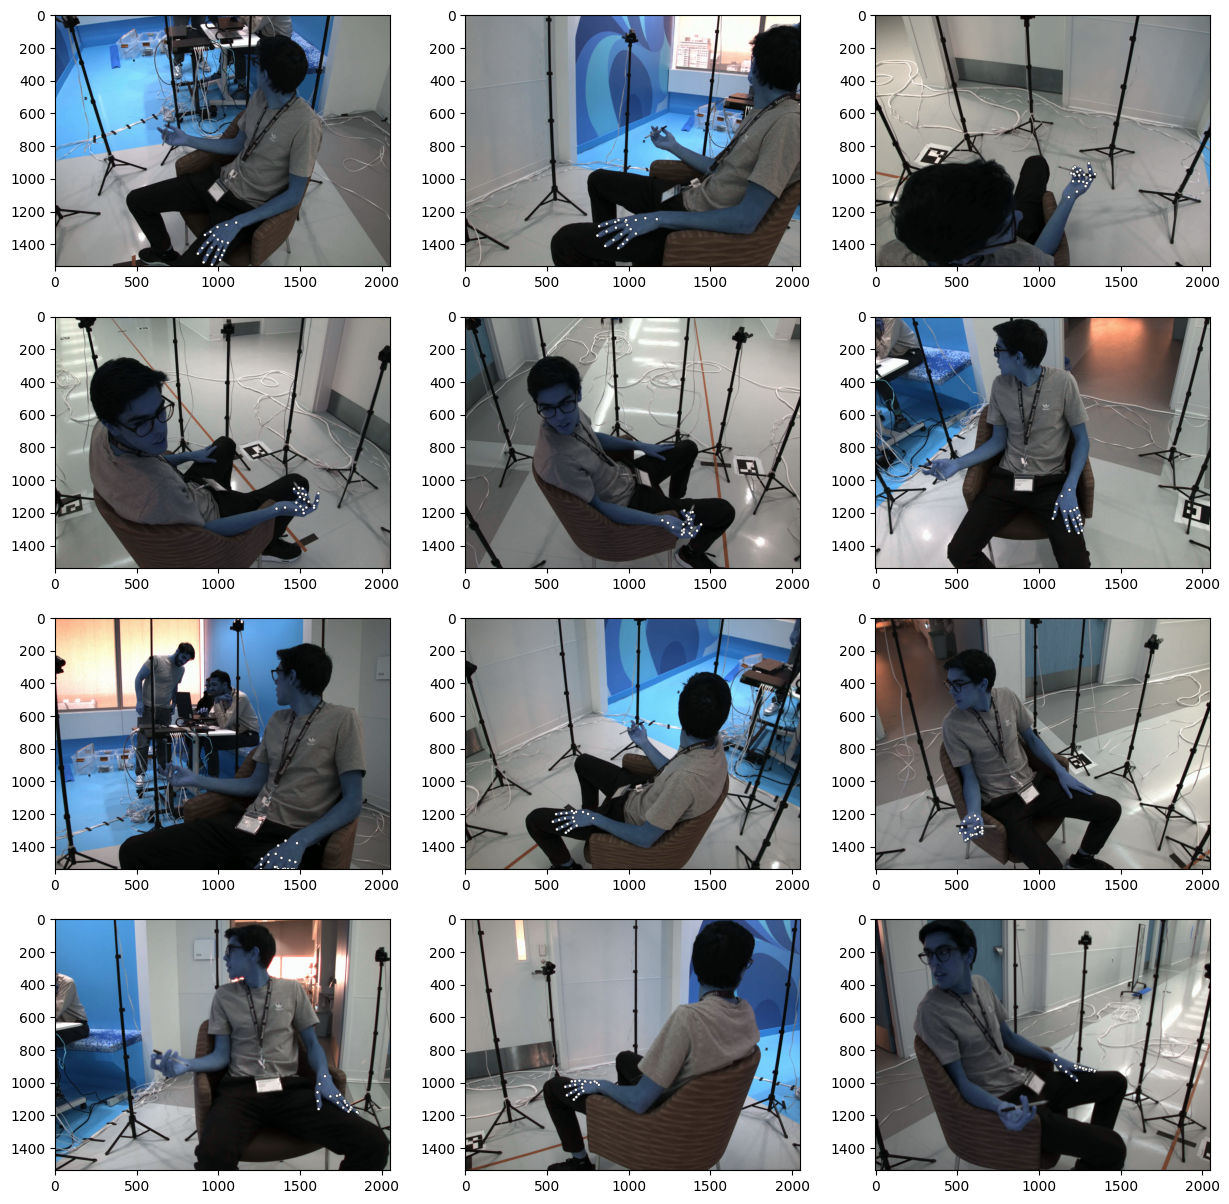

In [120]:
# using the variable axs for multiple Axes
n_cols = 3
fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))

for vid_idx in range(num_cameras):
    vid_file = (Video &vid_keys[vid_idx]).fetch('video')[0]
    # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
    
    cap = cv2.VideoCapture(vid_file)
    frame_idx = 0
    video_writer = None
    pred_instances_list = []
    keypoints_2d = (HandPoseEstimation & vid_keys[vid_idx]).fetch1("keypoints_2d")
    ###############################CHOOSE A FRAME#########################
    # while frame_idx < 1:
    success, frame = cap.read()
    frame_idx += 1

    if not success:
        break
    radius = 10
    threshold = 0.2
    color = (255,255,255)
    border_color = (0,0,0)
    keypoints = keypoints_2d[frame_idx,:,:].copy()
    keypoints[..., 0] = np.clip(keypoints[..., 0], 0, frame.shape[1])
    keypoints[..., 1] = np.clip(keypoints[..., 1], 0, frame.shape[0])
    for i in range(keypoints.shape[0]):
        if keypoints[i,-1] > threshold:
            cv2.circle(frame, (int(keypoints[i, 0]), int(keypoints[i, 1])), radius, border_color, -1)
            if radius > 2:
                cv2.circle(frame, (int(keypoints[i, 0]), int(keypoints[i, 1])), radius - 2, color, -1)
    # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    row = vid_idx // n_cols
    col = vid_idx % n_cols
    axs[row,col].imshow(frame)
    os.remove(vid_file)